<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "IT-L4"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/IT-L4/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


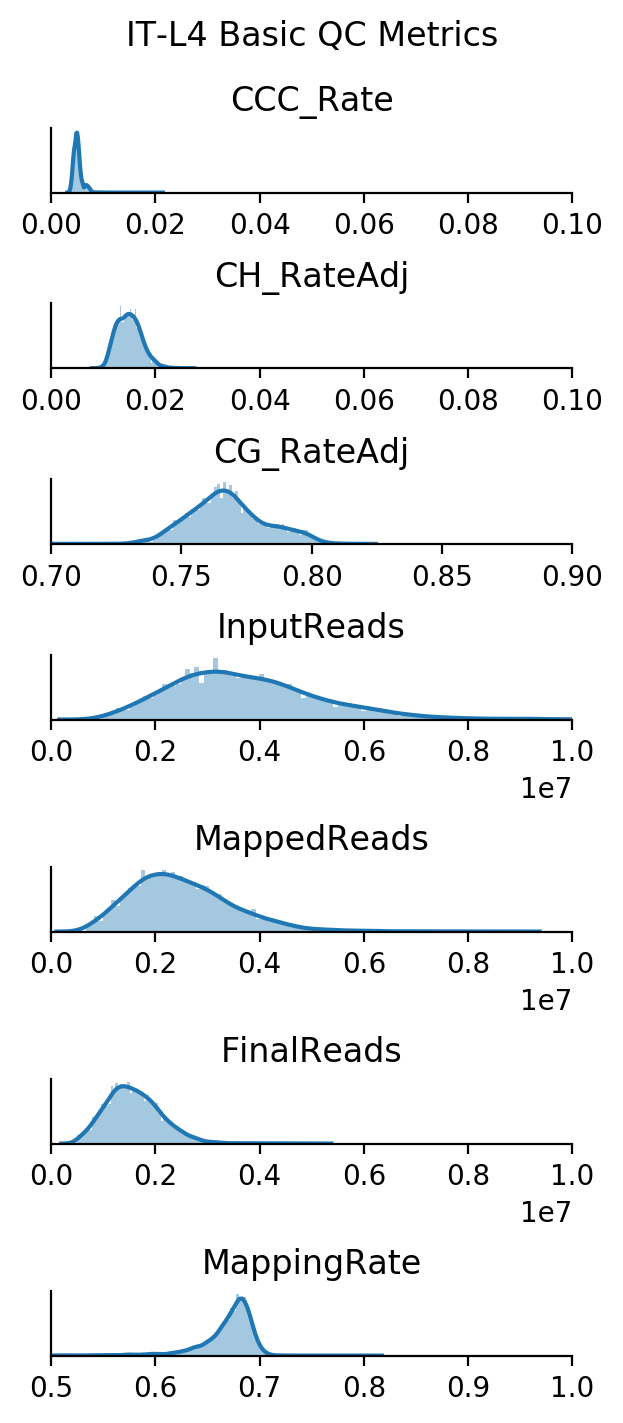

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

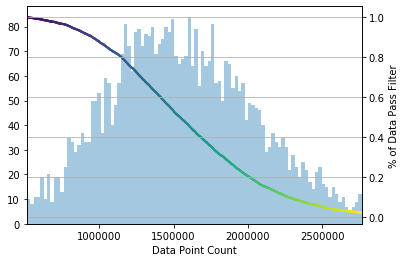

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 4347/4347 (100.0%)
CG_RateAdj passed 4347/4347 (100.0%)
CH_RateAdj passed 4347/4347 (100.0%)
FinalReads passed 4347/4347 (100.0%)
MappingRate passed 4347/4347 (100.0%)
Overall passed 4347/4347 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171206 132
171207 151
171212 25
171213 101
180104 161
180119 3
180205 1
180206 1
180208 1
180213 7
180222 1
180226 76
180227 70
180305 42
180306 47
180312 48
180320 1
180409 138
180410 132
180412 38
180416 20
180417 181
180419 182
180423 213
180424 169
180426 225
180430 249
180501 59
180514 198
180529 253
180605 105
180612 119
180806 1
181002 150
181022 222
181023 244
181204 1
181206 1
181210 170
190108 1
190117 27
190122 177
190124 198
190131 3
190205 1
190212 1
190307 1


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 561 146.1%
ad002 571 148.7%
ad004 533 138.8%
ad006 519 135.2%
ad007 552 143.8%
ad008 539 140.4%
ad010 528 137.5%
ad012 544 141.7%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
1A_M_0,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.004240,0.766260,0.765260,0.020970,0.016800,1932779.0,4061840,2765172.0,1A,...,-15.305650,-31.432518,-10.134626,-25.729062,IT-L4,4.680958,-14.896851,-23.386248,7.072172,True
1A_M_1,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.004220,0.759720,0.758700,0.020320,0.016170,1549132.0,3240886,2226396.0,1A,...,-15.099611,-30.587414,-11.878137,-25.066417,IT-L4,4.684537,-13.507821,-6.264395,7.254069,True
1A_M_1016,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.003830,0.775470,0.774610,0.017480,0.013700,1073350.0,2285652,1576146.0,1A,...,-14.600449,-31.718901,-8.373829,-24.201141,IT-L4,5.397864,-14.249078,-8.000830,3.351527,True
1A_M_102,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.004360,0.776100,0.775120,0.020050,0.015760,1806773.0,4319514,2919403.0,1A,...,-14.969831,-30.827158,-11.157435,-24.777325,IT-L4,5.074982,-13.745018,-7.116569,5.734859,True
1A_M_1046,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.003890,0.765420,0.764500,0.017410,0.013570,1955493.0,4489924,3068959.0,1A,...,-15.041784,-31.501484,-9.945544,-25.566981,IT-L4,5.035552,-15.020240,-23.307212,6.818469,True
1A_M_1056,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.004450,0.773460,0.772450,0.021160,0.016780,2079330.0,4368468,3005985.0,1A,...,-15.129269,-30.522215,-12.101765,-24.519894,IT-L4,4.985972,-13.475275,-5.860836,7.311107,True
1A_M_1101,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.004260,0.762560,0.761540,0.020970,0.016780,2415035.0,5915558,4031761.0,1A,...,-14.346444,-30.658770,-11.575003,-24.599767,IT-L4,5.710891,-13.420415,-7.096303,6.402235,True
1A_M_1118,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.004110,0.765510,0.764540,0.019580,0.015530,1422430.0,3068362,2117758.0,1A,...,-14.680737,-31.004360,-10.700651,-24.556382,IT-L4,5.371474,-13.673536,-6.862591,5.477736,True
1A_M_1141,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.004250,0.770280,0.769300,0.019760,0.015580,1913195.0,4517590,3042449.0,1A,...,-15.682129,-30.500513,-12.657142,-25.676971,IT-L4,4.243533,-13.370111,-6.485155,8.157195,True
